In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
import igraph
pd.set_option('display.max_columns', 30)

In [39]:
ddir = "/home/scai/PhenPred/data/"
data_folder = "/home/scai/PhenPred/data/clines"

In [3]:
ss_cmp = pd.read_csv(f"{data_folder}/model_list_20230505.csv", index_col=0)

# Growth
growth = pd.read_csv(f"{data_folder}/growth_rate_20220907.csv")
growth = (
    growth.sort_values(["model_id", "replicates"], ascending=False)
    .groupby("model_id")
    .first()
)
growth = growth.dropna(subset=["day4_day1_ratio"])


In [4]:
gexp_measured = pd.read_csv(
    f"{data_folder}/depmap23Q2/OmicsExpressionGenesExpectedCountProfileVoom.csv",
    index_col=0,
).T
gexp_measured = gexp_measured.rename(
    index=ss_cmp.reset_index().groupby("BROAD_ID").first()["model_id"]
)

In [5]:
## CRISPR-Cas9
cas9_measured = pd.read_csv(
    f"{data_folder}/depmap23Q2/CRISPRGeneEffect.csv", index_col=0
)
cas9_measured.columns = cas9_measured.columns.str.split(" ").str[0]
# cas9_measured = scale(cas9_measured.T).T
cas9_measured = cas9_measured.rename(
    index=ss_cmp.reset_index().groupby("BROAD_ID").first()["model_id"]
)

In [6]:
measured_gexp_only = list(set(gexp_measured.index) - set(cas9_measured.index))
measured_cas9_only = list(set(cas9_measured.index) - set(gexp_measured.index))
measured_both = list(set(gexp_measured.index) & set(cas9_measured.index))

In [7]:
measured_groups = {
    "both": measured_both,
    "gexp_only": measured_gexp_only,
    "cas9_only": measured_cas9_only,
    "none": [],  # Will be automatically assigned for remaining samples
}

In [8]:
timestamp = "20241211_171745"
# Datasets - synthetic
## Transcriptomics
gexp_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_transcriptomics.csv.gz",
    index_col=0,
)

## CRISPR-Cas9
cas9_df = pd.read_csv(
    f"/home/scai/PhenPred/reports/vae/files/{timestamp}_imputed_crisprcas9.csv.gz",
    index_col=0,
)

In [21]:
skew_df = pd.concat(
    [
        cas9_measured.apply(skew).astype(float).rename("skew_orig"),
        cas9_df.apply(skew).astype(float).rename("skew_mosa"),
    ],
    axis=1,
)

def build_string_ppi(score_thres=900):
    # ENSP map to gene symbol
    gmap = pd.read_csv(f"../data/ppi/9606.protein.aliases.v12.0.txt.gz", sep="\t")
    gmap = gmap[["BioMart_HUGO" in i.split(" ") for i in gmap["source"]]]
    gmap = gmap.groupby("#string_protein_id")["alias"].agg(lambda x: set(x)).to_dict()
    gmap = {k: list(gmap[k])[0] for k in gmap if len(gmap[k]) == 1}

    # Load String network
    net = pd.read_csv(f"../data/ppi/9606.protein.links.full.v12.0.txt.gz", sep=" ")

    # Filter by moderate confidence
    net = net[net["combined_score"] > score_thres]

    # Filter and map to gene symbol
    net = net[
        [p1 in gmap and p2 in gmap for p1, p2 in net[["protein1", "protein2"]].values]
    ]
    net["protein1"] = [gmap[p1] for p1 in net["protein1"]]
    net["protein2"] = [gmap[p2] for p2 in net["protein2"]]

    #  String network
    net_i = igraph.Graph(directed=False)

    # Initialise network lists
    edges = [(px, py) for px, py in net[["protein1", "protein2"]].values]
    vertices = list(set(net["protein1"]).union(net["protein2"]))

    # Add nodes
    net_i.add_vertices(vertices)

    # Add edges
    net_i.add_edges(edges)

    # Add edge attribute score
    net_i.es["score"] = list(net["combined_score"])

    # Simplify
    net_i = net_i.simplify(combine_edges="max")

    return net_i
ppi = build_string_ppi()
def ppi_dist_to_string(d, target_thres):
    if d == 0:
        res = "T"

    elif d == np.inf:
        res = "No link; No connection"

    elif d < target_thres:
        res = f"{int(d)}"

    else:
        res = f"{int(target_thres)}+"

    return res


def dist_crispr_gexp(crisprs, gexps, ppi):
    ppi_genes = set(ppi.vs["name"])
    genes = gexps.intersection(ppi_genes)
    assert len(genes) != 0, "No gexps overlapping with PPI provided"

    dmatrix = {
        c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))
        for c in crisprs
        if c in ppi_genes
    }

    return dmatrix


def ppi_annotation(df, ppi, target_thres=5):
    df_genes = set(df["x_id"])
    df_crispr = set(df["y_id"])

    # Calculate distance between gexp and crispr in PPI
    dist_d_g = dist_crispr_gexp(df_crispr, df_genes, ppi)

    # Annotate drug regressions
    def drug_gene_annot(c, g):
        if c == g:
            res = "T"

        elif c not in dist_d_g:
            res = "No link; CRISPR not in network"

        elif g not in dist_d_g[c]:
            res = "No link; Gene not in network"

        else:
            res = ppi_dist_to_string(dist_d_g[c][g], target_thres)

        return res

    df = df.assign(
        target_detailed=[
            drug_gene_annot(c, g) for c, g in df[["y_id", "x_id"]].values
        ]
    )

    df = df.assign(
        target=["-" if t.startswith("No link;") else t for t in df["target_detailed"]]
    )

    return df

# pan-cancer level

In [10]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9.csv.gz"
)
df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
df_res_vae['diff_log10p'] = df_res_vae['log10p_vae'] - df_res_vae['log10p_orig']
df_res_vae = df_res_vae.sort_values("diff_log10p", ascending=False)

In [11]:
df_res_vae_annot = pd.merge(df_res_vae, skew_df, left_on="y_id", right_index=True)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)

/tmp/ipykernel_2693504/1231999447.py:71: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))


In [31]:
df_res_vae_annot.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot.csv.gz"
)

In [122]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot.csv.gz",index_col=0
)

In [123]:
df_res_vae_annot['log10fdr_orig'] = -np.log10(df_res_vae_annot['fdr_orig'])
df_res_vae_annot['log10fdr_vae'] = -np.log10(df_res_vae_annot['fdr_vae'])
df_res_vae_annot['diff_log10fdr'] = df_res_vae_annot['log10fdr_vae'] - df_res_vae_annot['log10fdr_orig']

In [46]:
df_res_vae_annot.head()

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,lr_vae,covs_vae,pval_vae,fdr_vae,log10p_orig,log10p_vae,diff_log10p,skew_orig,skew_mosa,target_detailed,target,log10fdr_orig,log10fdr_vae,diff_log10fdr
2,SOX10,SOX10,923.0,-0.046539,599.856935,16.0,1.798527e-132,3.093825e-128,1523.0,-0.044284,1070.501259,19.0,8.518180e-235,4.794883e-231,131.745083,234.069653,102.324570,-3.568809,-3.268146,T,T,127.509504,230.319222,102.809718
16,SOX10,TYR,923.0,-0.038275,309.953187,16.0,2.235746e-69,3.845931e-65,1523.0,-0.038594,640.602168,19.0,2.471594e-141,1.391260e-137,68.650578,140.607023,71.956445,-3.568809,-3.268146,2,2,64.414999,136.856592,72.441593
11,SOX10,MMP8,923.0,-0.042217,321.713812,16.0,6.131954e-72,1.054819e-67,1523.0,-0.041850,650.103940,19.0,2.120832e-143,1.193816e-139,71.212401,142.673494,71.461093,-3.568809,-3.268146,No link; Gene not in network,-,66.976822,138.923063,71.946240
14,SOX10,ROPN1B,923.0,-0.042364,315.800861,16.0,1.190100e-70,2.047209e-66,1523.0,-0.041701,604.167061,19.0,2.076995e-133,1.169140e-129,69.924417,132.682565,62.758148,-3.568809,-3.268146,No link; Gene not in network,-,65.688838,128.932133,63.243296
12,SOX10,PLP1,923.0,-0.036811,320.822799,16.0,9.586905e-72,1.649139e-67,1523.0,-0.036564,604.412611,19.0,1.836652e-133,1.033851e-129,71.018322,132.735973,61.717652,-3.568809,-3.268146,2,2,66.782743,128.985542,62.202799


In [124]:
df_res_vae_filtered = df_res_vae_annot[df_res_vae_annot["beta_vae"].abs() > 0.02]
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_vae > 2")
df_res_vae_filtered = df_res_vae_filtered.query("log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_filtered[df_res_vae_filtered["target"].isin(['T', '1', '2', '3','4','5'])]
df_res_vae_filtered = df_res_vae_filtered.query("skew_orig < -2 and skew_mosa < -1.5")

In [125]:
COLS = ["y_id", "x_id", "beta_orig", "beta_vae", "fdr_orig", "fdr_vae", "diff_log10fdr", "skew_orig", "skew_mosa", "target"]

In [126]:
df_res_vae_filtered[COLS].to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_annot_filtered.csv", index=None
)

In [65]:
def plot_scatter(cas9_name, gexp_name, measured_groups=None, tissue=None, model_list_df=None):
    """
    Plot scatter with either all points or 4 measurement categories

    Parameters:
    -----------
    cas9: pd.Series
        CRISPR-Cas9 effects
    gexp: pd.Series
        Gene expression values
    measured_groups: dict, optional
        Dictionary with keys: 'both', 'gexp_only', 'cas9_only', 'none'
        containing lists of sample IDs for each category
    """
    cas9 = cas9_df[cas9_name]
    gexp = gexp_df[gexp_name]
    if tissue is not None and model_list_df is not None:
        # Filter data
        model_list = model_list_df[model_list_df["tissue"] == tissue].index.values
        cas9 = cas9[cas9.index.isin(model_list)]
        gexp = gexp[gexp.index.isin(model_list)]

    # Merge data and get common samples
    df = pd.DataFrame({"CRISPR": cas9, "Expression": gexp})
    df = df.dropna()

    # Calculate correlation
    corr, pval = stats.pearsonr(df["CRISPR"], df["Expression"])

    # Create plot
    plt.figure(figsize=(6, 6))

    if measured_groups is None:
        # Simple case: plot all points in green
        plt.scatter(
            df["Expression"],
            df["CRISPR"],
            c="green",
            alpha=0.6,
            label=f"All samples (n={len(df)})",
        )
    else:
        # Complex case with categories
        def get_category(idx):
            for cat in ["both", "gexp_only", "cas9_only"]:
                if idx in measured_groups[cat]:
                    return cat
            return "none"

        df["Category"] = df.index.map(get_category)

        n_both = df["Category"].value_counts().get("both", 0)
        n_gexp = df["Category"].value_counts().get("gexp_only", 0)
        n_cas9 = df["Category"].value_counts().get("cas9_only", 0)
        n_none = df["Category"].value_counts().get("none", 0)

        # Create color and label mapping
        category_config = {
            "both": {"color": "green", "label": f"Both Measured (N={n_both})"},
            "gexp_only": {"color": "blue", "label": f"Expression Only (N={n_gexp})"},
            "cas9_only": {"color": "gray", "label": f"CRISPR Only (N={n_cas9})"},
            "none": {"color": "red", "label": f"Both Imputed (N={n_none})"},
        }

        # Plot scatter points for each category
        for category, config in category_config.items():
            mask = df["Category"] == category
            if mask.any():
                plt.scatter(
                    df.loc[mask, "Expression"],
                    df.loc[mask, "CRISPR"],
                    c=config["color"],
                    alpha=0.6,
                    label=config["label"],
                )

    # Add regression line
    sns.regplot(
        data=df,
        y="CRISPR",
        x="Expression",
        scatter=False,
        color="black",
        line_kws={"linestyle": "--"},
    )

    # Annotate correlation
    plt.annotate(
        f"r = {corr:.3f}\np = {pval:.2e}\nn = {len(df)}",
        xy=(0.05, 0.85),
        xycoords="axes fraction",
        bbox=dict(facecolor="white", alpha=0.8),
    )

    # Labels and title
    plt.ylabel(f"{cas9_name} (Cas9)")
    plt.xlabel(f"{gexp_name} (GEXP)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    title = f"{cas9_name} (Cas9) vs {gexp_name} (GEXP)"
    if tissue is not None:
        title += f" ({tissue})"
    plt.title(title)

    return plt.gca()

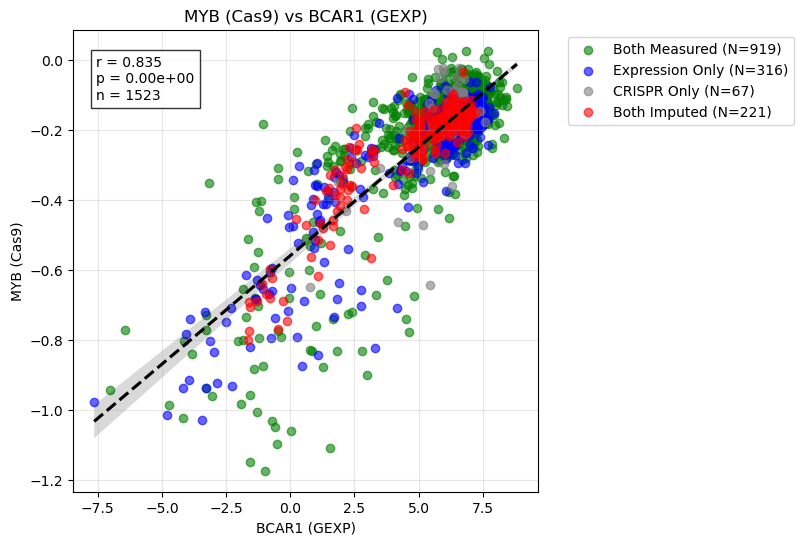

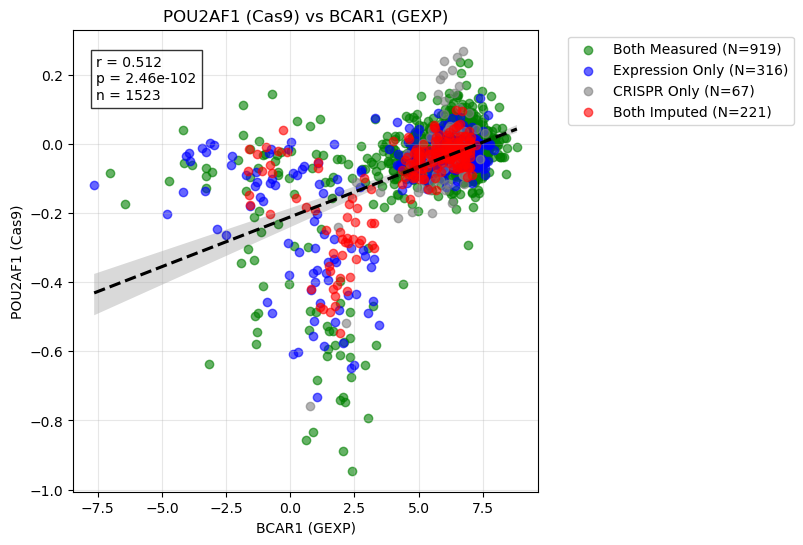

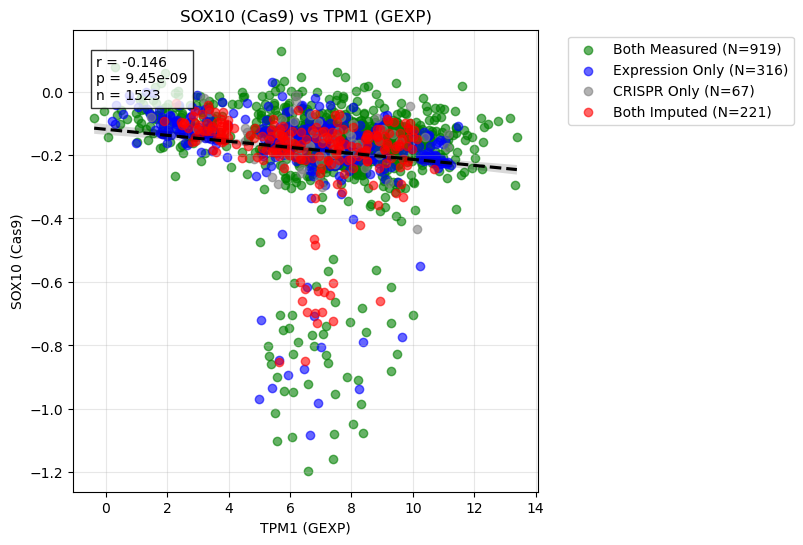

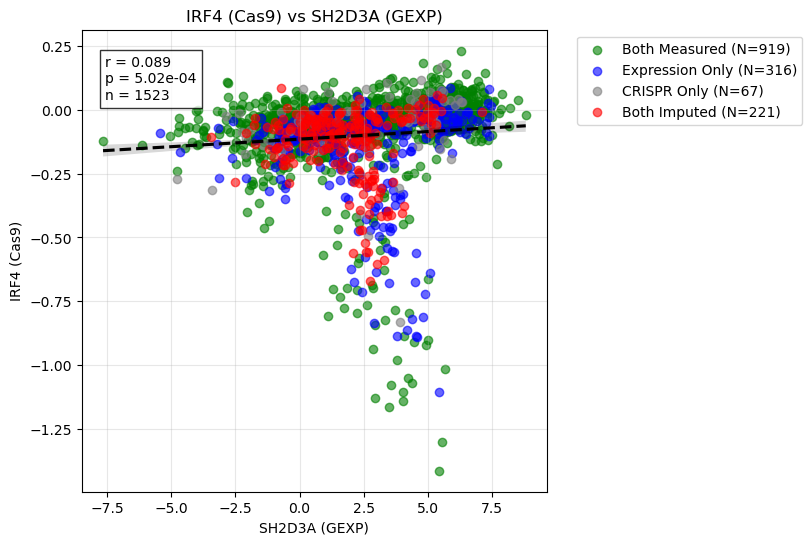

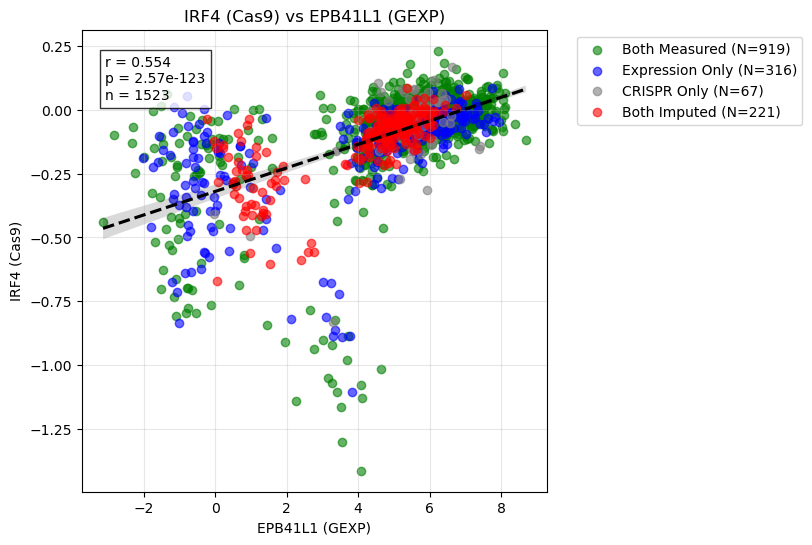

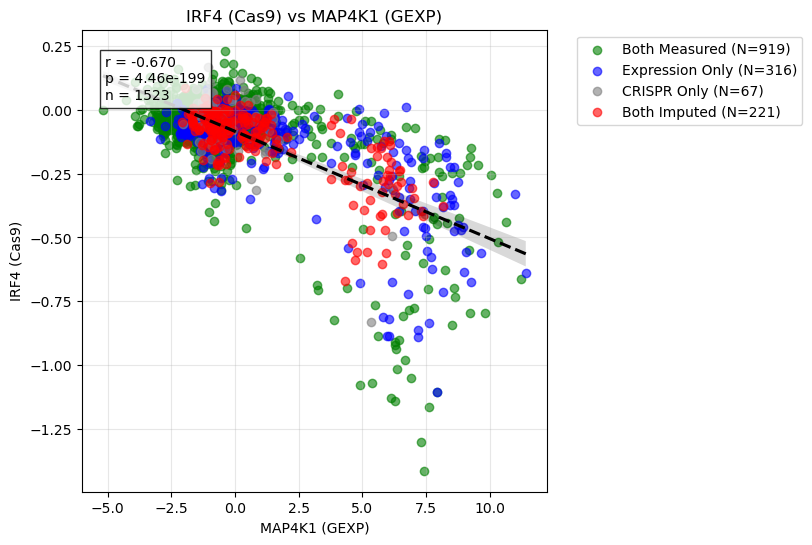

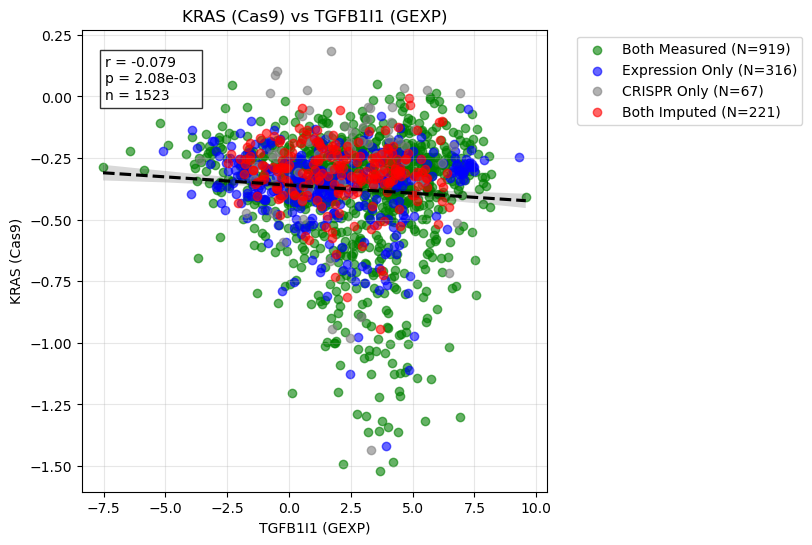

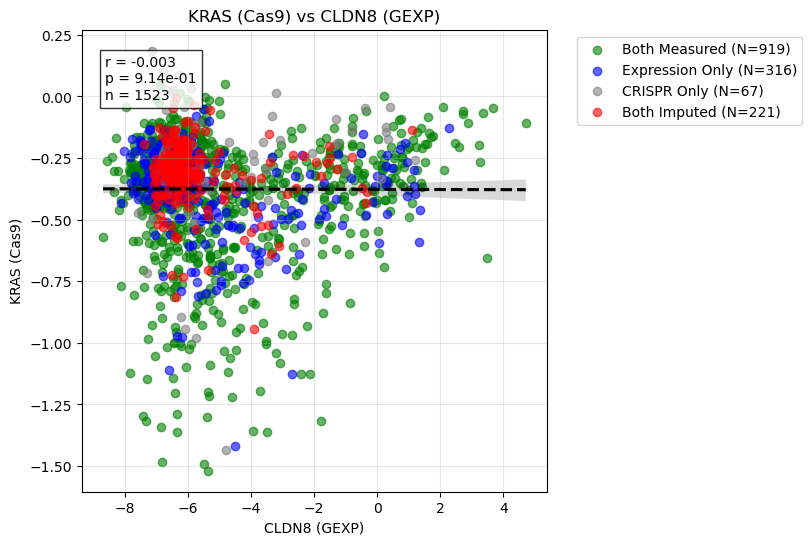

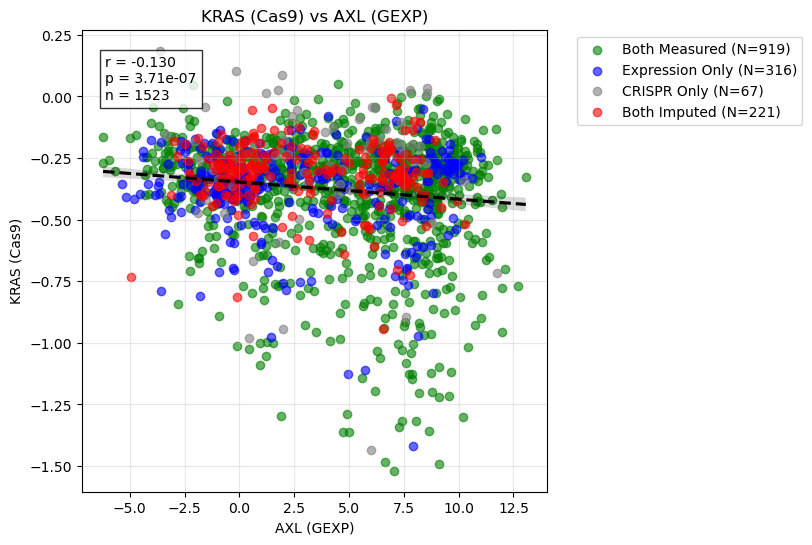

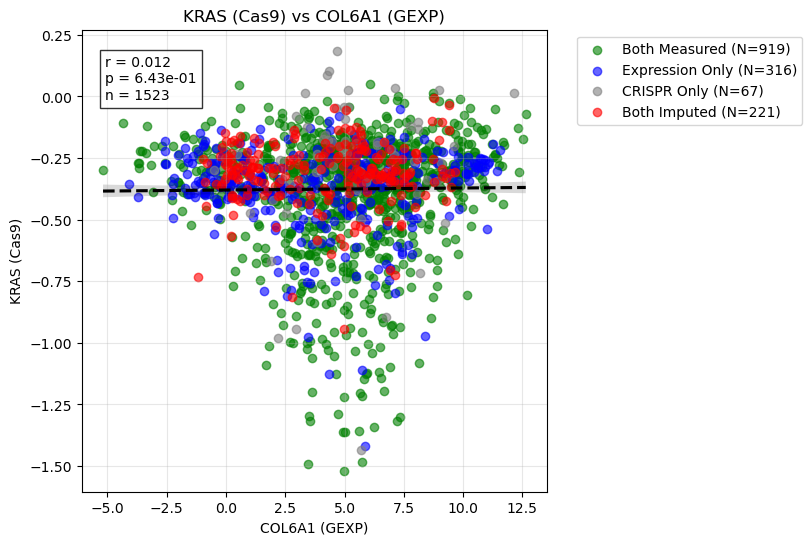

In [92]:
for row in df_res_vae_filtered[COLS].head(10).itertuples():
    plot_scatter(row.y_id, row.x_id, measured_groups=measured_groups, tissue=None, model_list_df=ss_cmp)

In [ ]:
plot_scatter("MYB", "BCAR1", measured_groups=measured_groups, model_list_df=ss_cmp)

# tissue level

In [94]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue.csv.gz"
)


In [98]:
df_res_vae["log10p_orig"] = -np.log10(df_res_vae["pval_orig"])
df_res_vae["log10p_vae"] = -np.log10(df_res_vae["pval_vae"])
df_res_vae["diff_log10p"] = df_res_vae["log10p_vae"] - df_res_vae["log10p_orig"]
df_res_vae["log10fdr_orig"] = -np.log10(df_res_vae["fdr_orig"])
df_res_vae["log10fdr_vae"] = -np.log10(df_res_vae["fdr_vae"])
df_res_vae["diff_log10fdr"] = df_res_vae["log10fdr_vae"] - df_res_vae["log10fdr_orig"]
df_res_vae = df_res_vae.sort_values("diff_log10fdr", ascending=False)

In [95]:
df_res_vae.loc[:,"n_samples_diff"] = (
    df_res_vae["n_samples_vae"] - df_res_vae["n_samples_orig"]
)
df_res_vae.loc[:,"n_samples_diff_pct"] = (
    df_res_vae["n_samples_diff"] / df_res_vae["n_samples_orig"]
)

In [112]:
df_res_vae_filtered = df_res_vae.query("log10fdr_vae > 2 and log10fdr_orig < 2")
df_res_vae_filtered = df_res_vae_filtered[df_res_vae["beta_vae"].abs() > 0.03]
df_res_vae_annot = pd.merge(
    df_res_vae_filtered, skew_df, left_on="y_id", right_index=True
)
df_res_vae_annot = ppi_annotation(df_res_vae_annot, ppi)
df_res_vae_annot = df_res_vae_annot[
    df_res_vae_annot["target"].isin(["T", "1", "2", "3", "4", "5"])
]
df_res_vae_annot = df_res_vae_annot.query("skew_orig < -2 and skew_mosa < -1.5")

/tmp/ipykernel_2755579/3966007396.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_res_vae_filtered = df_res_vae_filtered[df_res_vae["beta_vae"].abs() > 0.03]
/tmp/ipykernel_2755579/1231999447.py:71: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  c: dict(zip(*(genes, ppi.shortest_paths(source=c, target=genes)[0])))


In [114]:
df_res_vae_annot[COLS+['tissue']]

,y_id,x_id,beta_orig,beta_vae,fdr_orig,fdr_vae,diff_log10fdr,skew_orig,skew_mosa,target,tissue
1251,IRF4,LMO2,0.035601,0.031896,0.132610,0.000008,4.213544,-4.030987,-2.930561,3,Haematopoietic and Lymphoid
35710936,ERBB2,COL17A1,0.059124,0.060168,0.030290,0.000020,3.181697,-3.626524,-2.416997,2,Stomach
16553988,IRS1,MME,0.031057,0.031014,0.022741,0.000089,2.407932,-2.536315,-1.590119,3,Bone
17124648,FLI1,OTX2,-0.034947,-0.046081,0.273516,0.001488,2.264483,-3.826197,-3.105889,4,Bone
11017058,WRN,CACNG4,0.065941,0.057196,0.236776,0.001318,2.254392,-4.776865,-3.085637,4,Large Intestine
2756661,KRAS,AREG,-0.034328,-0.032931,0.340522,0.002127,2.204476,-2.230009,-1.750527,2,Lung
14009470,BRAF,ST14,-0.013162,-0.036056,0.426680,0.006446,1.820789,-3.054024,-2.870718,3,Breast
27467244,NFE2L2,CFI,0.038795,0.034510,0.052657,0.000907,1.763652,-2.294134,-1.526238,4,Kidney
43962780,NFE2L2,AKR1B10,-0.023644,-0.038361,0.137257,0.003268,1.623205,-2.294134,-1.526238,4,Biliary Tract
27497663,NFE2L2,HAVCR1,0.064776,0.060166,0.090046,0.002218,1.608485,-2.294134,-1.526238,4,Kidney


In [111]:
df_res_vae_filtered.query("y_id == 'KRAS' and x_id == 'AREG'")

,y_id,x_id,n_orig,beta_orig,lr_orig,covs_orig,pval_orig,fdr_orig,n_vae,beta_vae,lr_vae,covs_vae,pval_vae,fdr_vae,tissue,n_samples_orig,n_samples_vae,log10p_orig,log10p_vae,diff_log10p,n_samples_diff,n_samples_diff_pct,log10fdr_orig,log10fdr_vae,diff_log10fdr


In [ ]:
df_res_vae.to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered.csv",
    index=False,
)

In [13]:
df_res_vae = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered.csv"
)

In [121]:
df_res_vae_annot[COLS + ["tissue"]].to_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered_annot.csv", index=None
)

In [15]:
df_res_vae_annot = pd.read_csv(
    f"../reports/vae/crispr/{timestamp}_transcriptomics_crisprcas9_tissue_filtered_annot.csv"
)

In [16]:
df_res_vae[
    ["tissue", "n_samples_orig", "n_samples_diff", "n_samples_diff_pct"]
].drop_duplicates().sort_values("n_samples_diff_pct")

,tissue,n_samples_orig,n_samples_diff,n_samples_diff_pct
19,Biliary Tract,31,4,0.129032
54,Bladder,32,6,0.187500
92,Pancreas,43,10,0.232558
159,Soft Tissue,42,12,0.285714
2,Esophagus,29,9,0.310345
763,Ovary,50,16,0.320000
181,Large Intestine,50,24,0.480000
641,Head and Neck,45,23,0.511111
97,Breast,44,25,0.568182
38,Stomach,28,16,0.571429


In [17]:
df_res_vae_annot['target'].value_counts()

target
-     471
5+    235
4     133
3      65
2       9
1       2
T       1
Name: count, dtype: int64

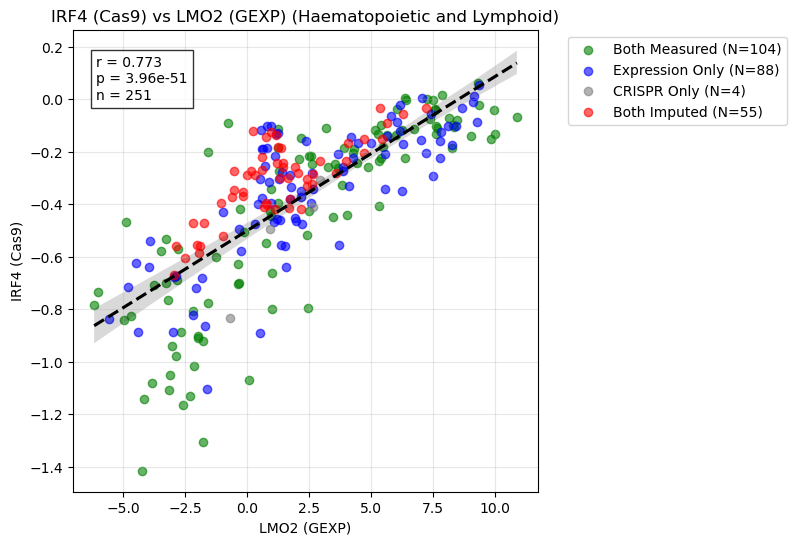

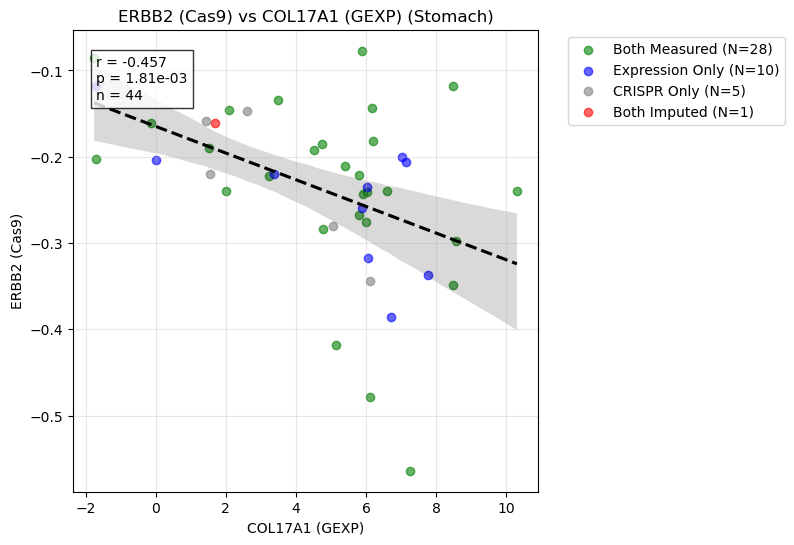

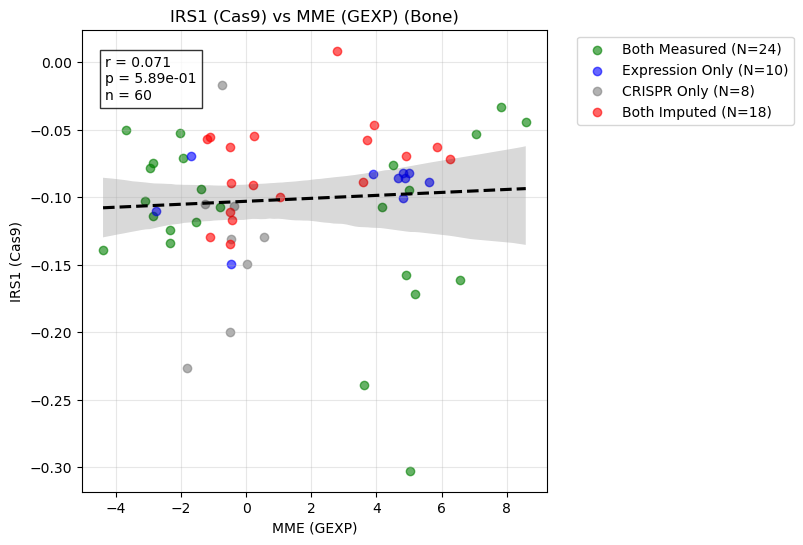

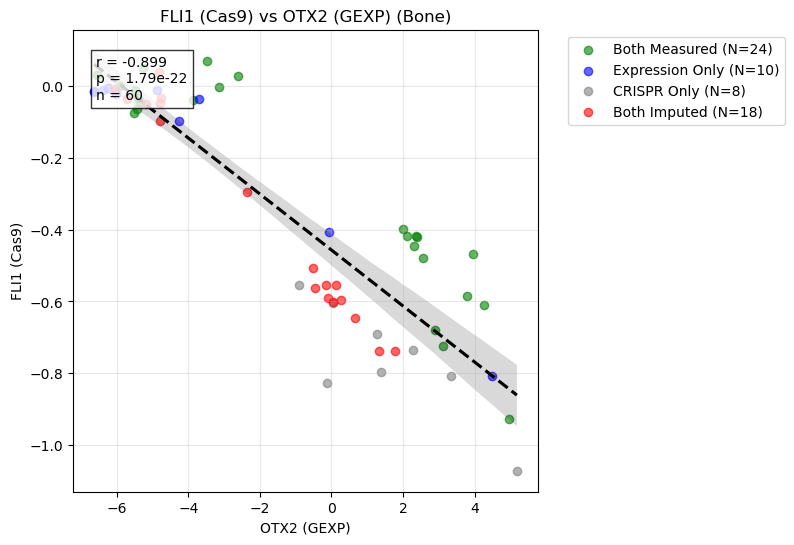

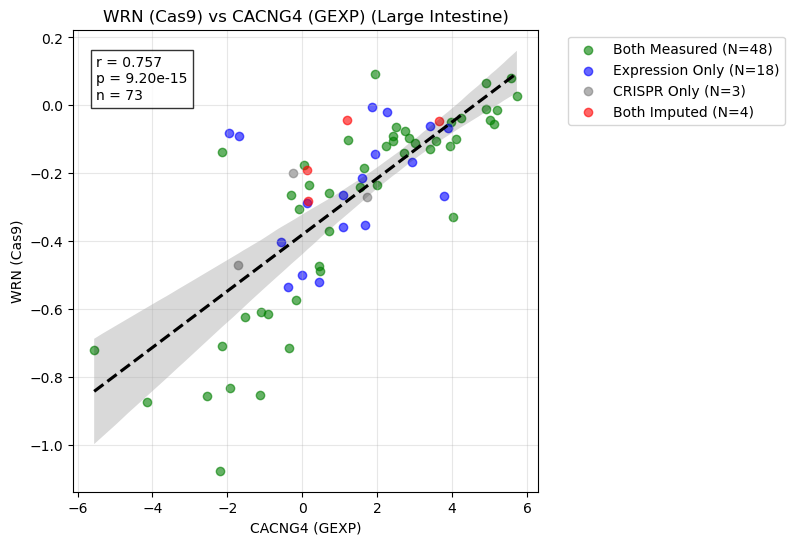

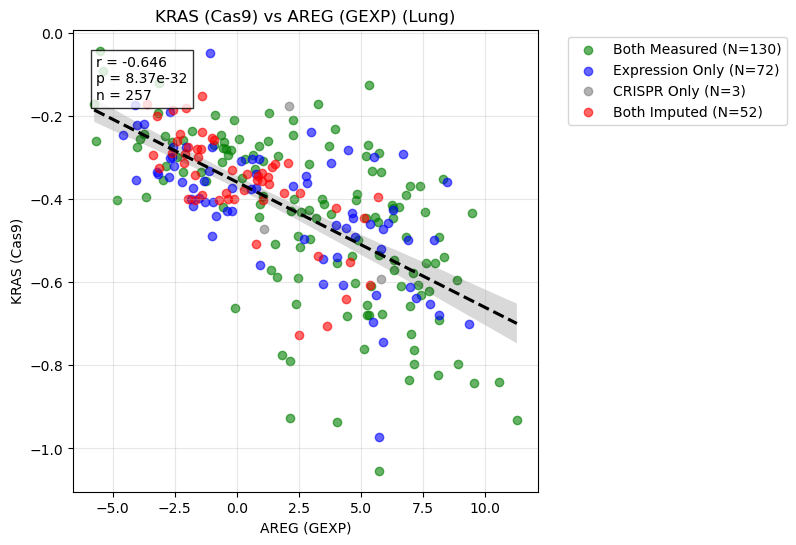

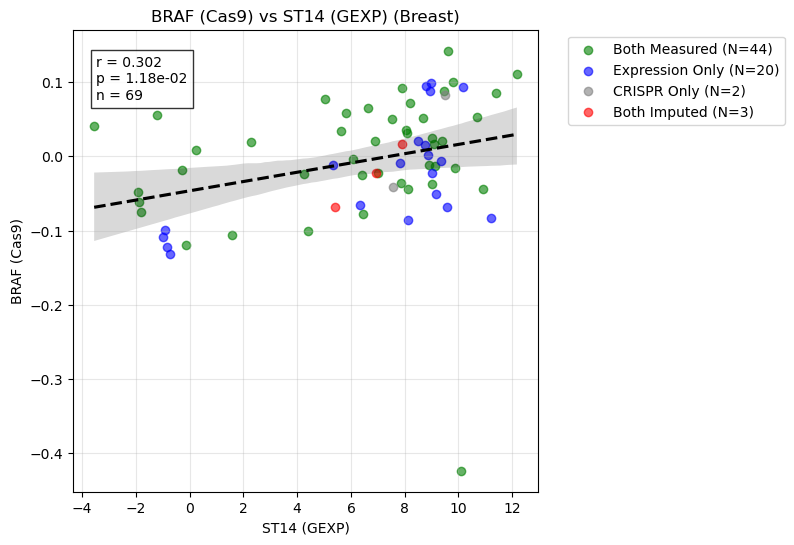

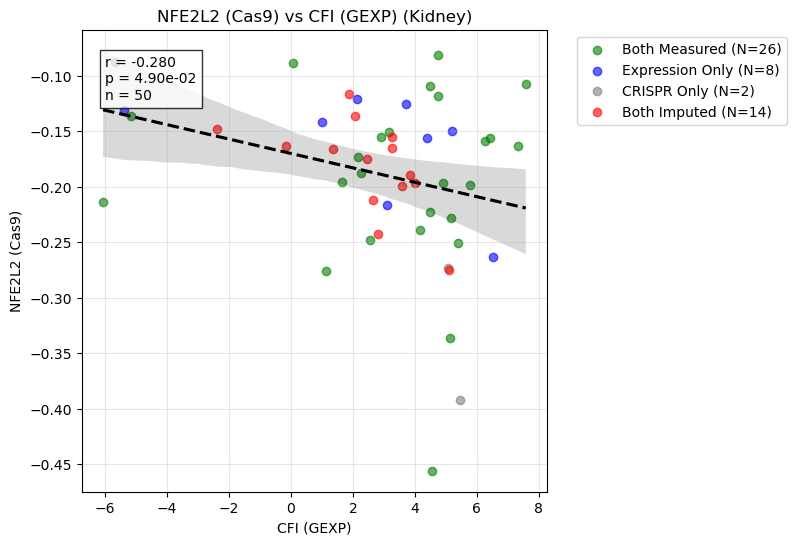

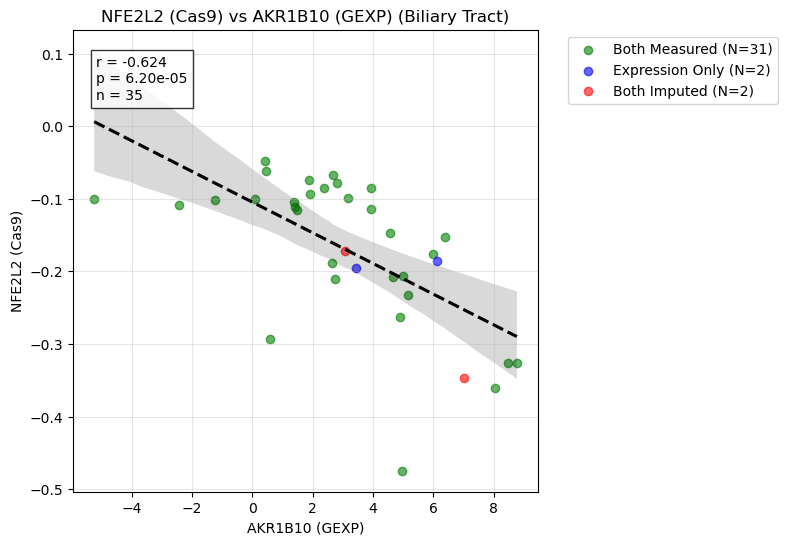

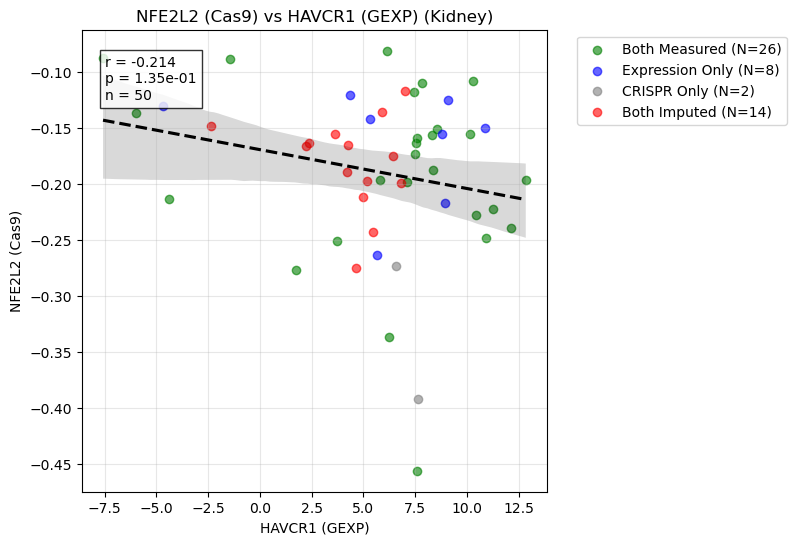

In [120]:
for row in df_res_vae_annot.head(10).itertuples():
    plot_scatter(row.y_id, row.x_id, measured_groups=measured_groups, tissue=row.tissue, model_list_df=ss_cmp)